In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, scipy.stats as stats, glob, os, random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## 20 positions version

no_noise


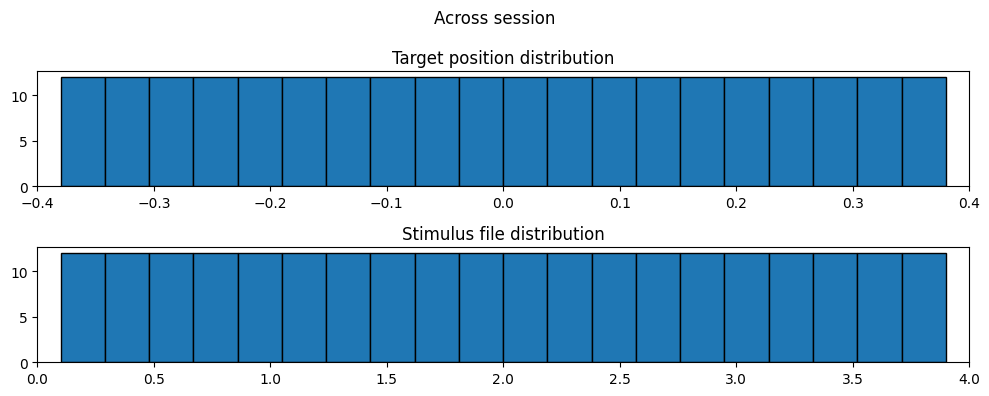

In [2]:
trial_info, trial_key, blockN = [], 0, 0

for run in [1,2]:

    for div in [0, -.2, .2]:
        
        blockN += 1

        # 1. sample 40 positions based on divider
        if div == 0:
            stim_file_pos_ls = np.round( np.sort( np.tile( np.arange(.1, 4.0, .2), 2 ) ), 1)
            
        elif div == -.2:
            stim_file_pos_ls = np.round( np.sort( np.tile( np.concatenate( [ np.arange(.1, 1.0, .2), np.arange(.1, 1.0, .2), np.arange(1.1, 3.0, .2) ] ), 2 ) ), 1)

        elif div == .2:
            stim_file_pos_ls = np.round( np.sort( np.tile( np.concatenate([ np.arange(1.1, 3.0, .2), np.arange(3.1, 4.0, .2), np.arange(3.1, 4.0, .2) ] ), 2 ) ), 1)

        # 2. sample valence display order
        shape_order_ls = ['curv_flat', 'flat_curv'] * 20

        # 3. sample noise
        version = ['patients', 'hard', 'no_noise'][2]
        noiseA, noiseB = (1.0, 3.0) if version == 'patients' else (0.0, 4.0) if version == 'hard' else (2.0, 2.0)
        noise_pos_ls = [noiseA] * 20 + [noiseB] * 20 if run == 1 else [noiseB] * 20 + [noiseA] * 20

        # 4. sample marker_init: 50-50 on right-left for each target category
        marker_init_dir = [-1, -1, 1, 1] * 40

        for i in range(len(stim_file_pos_ls)):
            
            # set some vars outside the loop
            stim_pos = round((stim_file_pos_ls[i] - 2) * .2, 2)
            target_pos = stim_pos if shape_order_ls[i] == 'curv_flat' else -stim_pos
            
            if marker_init_dir[i] < 0:
                marker_init = np.round( np.random.choice(np.arange(-.4, div, .004)), 3) #random.uniform(-.4, div)
                while not .05 < abs(target_pos-marker_init) <= .6 and marker_init!=div: # not too close or far
                    marker_init = np.round( np.random.choice(np.arange(-.4, div, .004)), 3) # random.uniform(-.4, div)

            elif marker_init_dir[i] > 0:
                marker_init = np.round( np.random.choice(np.arange(div, .4, .004)), 3) # random.uniform(div, .4)
                while not .05 < abs(target_pos-marker_init) <= .6 and marker_init!=div: # not too close or far
                    marker_init = np.round( np.random.choice(np.arange(div, .4, .004)), 3) # random.uniform(div, .4)

            img_prefix = 'input_data/stims/Shape_'

            # reminder: stim_file_pos (0,4), stim_pos (-.4,.4), target (-.4,.4)
            trial_info.append({
                    'blockN': blockN,
                    'run': run,
                    'condition': 'baseline' if div == 0 else 'curv_comp' if div == -.2 else 'flat_comp',
                    'trial_key': trial_key,

                    'stim_file_pos': stim_file_pos_ls[i],
                    'stim_pos': stim_pos,
                    'noise_pos': noise_pos_ls[i],
                    'marker_init': marker_init,
                    'shape': 'curv' if stim_pos <= div else 'flat',

                    'shape_order': shape_order_ls[i],
                    'div_pos': div if shape_order_ls[i] == 'curv_flat' else -div,
                    'target_pos': stim_pos if shape_order_ls[i] == 'curv_flat' else -stim_pos,

                    'subj_C0F1_val': 'pen' if stim_pos <= div else 'rew',
                    'subj_C1F0_val': 'rew' if stim_pos <= div else 'pen',                    

                    'target_file': f'{img_prefix}{stim_file_pos_ls[i]}0_{noise_pos_ls[i]}0.png',
                    'img1_file': f'{img_prefix}0.00_2.00.png' if shape_order_ls[i] == 'curv_flat'\
                            else f'{img_prefix}4.00_2.00.png',
                    'img2_file': f'{img_prefix}4.00_2.00.png' if shape_order_ls[i] == 'curv_flat'\
                            else f'{img_prefix}0.00_2.00.png'
                    })
            
            trial_key += 1

            
df = pd.DataFrame(trial_info)
# df.to_csv(f'../input_data/trials_{version}.csv', index=False)
print(version)

if version == 'patients':
    practice_ids = list(range(0, 60, 6)) + list(range(61, 120, 6))
    df_practice = df[df['trial_key'].isin(practice_ids)]
    df_practice.to_csv('../input_data/trials_practice.csv', index=False)

# across-session plot
fig, axs = plt.subplots(2, 1, figsize=(10, 4))
fig.suptitle('Across session')

ax = axs[0]
ax.hist(df['target_pos'], bins=20, edgecolor='black')
ax.set_title('Target position distribution')
ax.set_xlim(-.4, .4)

ax = axs[1]
ax.hist(df['stim_file_pos'], bins=20, edgecolor='black')
ax.set_title('Stimulus file distribution')
ax.set_xlim(.0, 4)

plt.tight_layout()
plt.show()


## noise-free or noised plot by divider

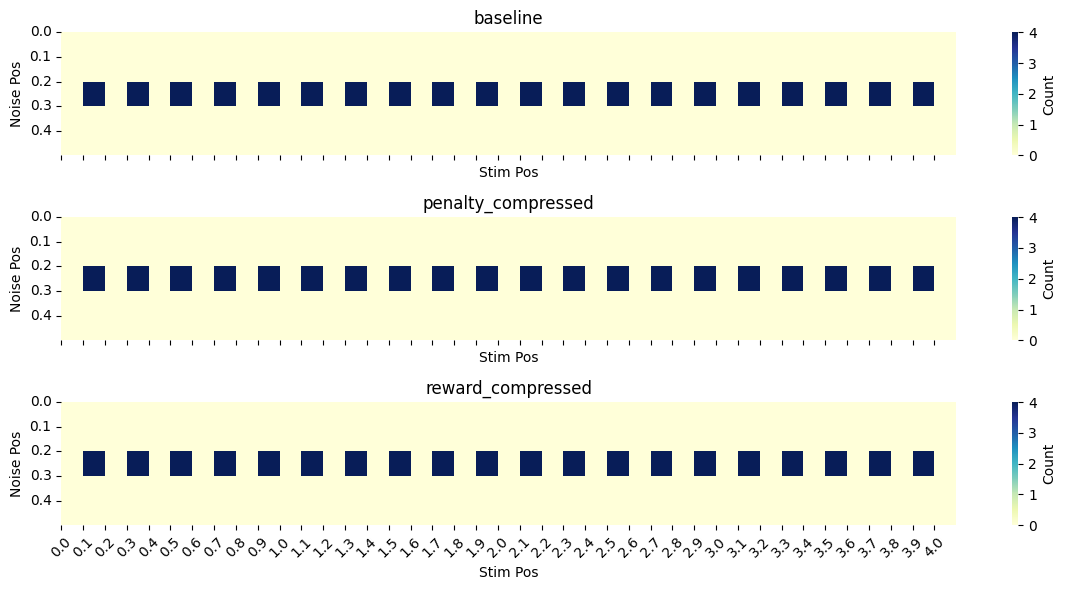

In [3]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 6), sharex=True)
comp_labels = ['baseline', 'penalty_compressed', 'reward_compressed']

# loop through dividers
for j, div in enumerate([.0, -.2, .2]):
    
    df_run_div = df[df['div_pos'] == div]
    ax = axs[j]

    # 1. plot noised version

    heatmap_data = np.zeros((5, 41))        
    for _, trial in df_run_div.iterrows():
        heatmap_data[int(trial['noise_pos']), int(10*trial['stim_file_pos'])] += 1

    sns.heatmap(heatmap_data, cmap="YlGnBu", ax=ax, 
                vmin=0, vmax=4,
                cbar_kws={
                    'label': 'Count',
                    'ticks': [0, 1, 2, 3, 4]
                })
    
    ax.set_title(f'{comp_labels[j]}')
    ax.set_xlabel('Stim Pos')
    ax.set_ylabel('Noise Pos')
    
    noise_ticks = np.arange(0, 5, 1)
    ax.set_yticks(noise_ticks)
    ax.set_yticklabels([str(i/10) for i in noise_ticks])
    ax.tick_params(axis='y', labelrotation=0)

    stim_ticks = np.arange(0, 41, 1)
    ax.set_xticks(stim_ticks)
    ax.set_xticklabels([str(i/10) for i in stim_ticks])
    ax.tick_params(axis='x', labelrotation=45)

    # 2. plot noise-less version

    # sns.histplot(df_run_div['target_pos'], bins=41, binrange=(-.4, .4), ax=ax)
    # ax.set_title(f'run: {run}, div: {div}')
    # ax.set_ylim(0, 10)

plt.tight_layout()
plt.show()


## plot each block

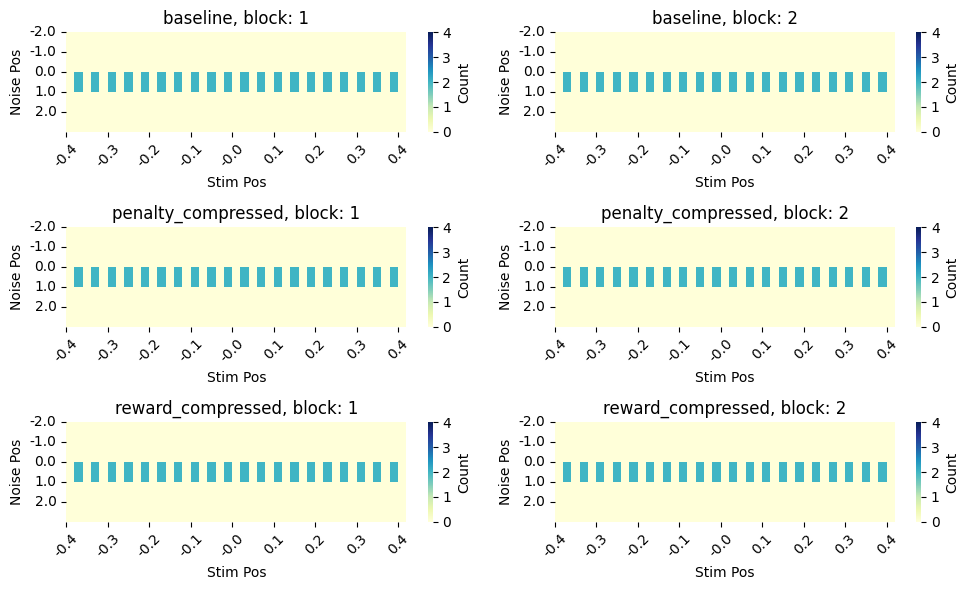

In [4]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 6))

# loop through runs & dividers
for i, run in enumerate([1, 2]):
    for j, div in enumerate([.0, -.2, .2]):
        
        df_run_div = df[(df['run'] == run) & (df['div_pos'] == div)]
        ax = axs[j, i]


        # 1. plot noised version

        heatmap_data = np.zeros((5, 41))        
        for _, trial in df_run_div.iterrows():
            heatmap_data[int(trial['noise_pos']), int(10*trial['stim_file_pos'])] += 1

        sns.heatmap(heatmap_data, cmap="YlGnBu", ax=ax, 
                    vmin=0, vmax=4,
                    cbar_kws={
                        'label': 'Count',
                        'ticks': [0, 1, 2, 3, 4]
                    })
        
        ax.set_title(f'{comp_labels[j]}, block: {run}')
        
        ax.set_xlabel('Stim Pos')
        ax.set_xticks(np.arange(0, 41, 5))  
        ax.set_xticklabels([f'{x:.1f}' for x in np.arange(-0.4, 0.5, 0.1)])  
        ax.tick_params(axis='x', labelrotation=45)

        ax.set_ylabel('Noise Pos')
        ax.set_yticks(np.arange(0, 5, 1))  
        ax.set_yticklabels([f'{y:.1f}' for y in np.arange(-2, 2.1, 1)])  
        ax.tick_params(axis='y', labelrotation=0)

        # 2. plot noise-less version

        # sns.histplot(df_run_div['stim_pos'], bins=41, binrange=(-.4, .4), ax=ax)
        # ax.set_xlabel('Stimulus position programmed')
        # # sns.histplot(df_run_div['target_pos'], bins=41, binrange=(-.4, .4), ax=ax)
        # # ax.set_xlabel('Stimulus position seen by subject')

        # ax.set_title(f'block: {run}, {comp_labels[j]}')
        # ax.set_ylim(0, 5)
        # ax.axvline(x=div, color='red', linestyle='--')
        # # ax.axvline(x=-div, color='red', linestyle='--')
        # if i == 0 and j == 0:
        #     ax.legend(['divider'], loc='upper right')

plt.tight_layout()
plt.show()

## histogram of trial-ease

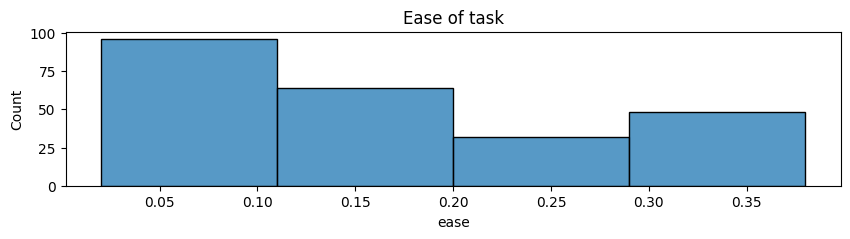

Proportion of trials where ease <= .1: 0.4


In [5]:
df['ease'] = abs(df['target_pos'] - df['div_pos'])
plt.figure(figsize=(10, 2))
sns.histplot(df['ease'], bins=4)
plt.title('Ease of task')
plt.show()

print(f"Proportion of trials where ease <= .1: {len(df[df['ease'] <= .1]) / len(df)}")

In [6]:
        # if div == 0:
        #     noise_pos_ls = [2.0] * 10  +  [0.0,4.0] * 10  +  [2.0] * 10 
        # elif div == -.2:
        #     noise_pos_ls = [2.0] * 10  +  [0.0,4.0] * 10  +  [2.0] * 10 if run == 1 else [2.0] * 10  +  [4.0,0.0] * 10  +  [2.0] * 10
        #     print(noise_pos_ls)
        # elif div == .2:
        #     noise_pos_ls = [2.0] * 10  +  [0.0,4.0] * 10  +  [2.0] * 10 if run == 2 else [2.0] * 10  +  [4.0,0.0] * 10  +  [2.0] * 10



# a1 = [2.0] * 10  +  [0.0] * 20  +  [2.0] * 10 
# a2 = [2.0] * 10  +  [4.0] * 20  +  [2.0] * 10 

# b1 = [2.0] * 5 + [0.0] * 15  +  [2.0] * 20
# b2 = [2.0] * 5 + [4.0] * 15  +  [2.0] * 20

# c1 = [2.0] * 20  +  [0.0] * 15  +  [2.0] * 5
# c2 = [2.0] * 20  +  [4.0] * 15  +  [2.0] * 5

# fig, axs = plt.subplots(3, 1, figsize=(4, 6))

# ax = axs[0]
# ax.plot(a1)
# ax.plot(a2)
# ax.set_ylabel('noise')
# ax.set_xlabel('stim')
# ax.axvline(x=20, color='r', linestyle='--')

# ax = axs[1]
# ax.plot(b1)
# ax.plot(b2)
# ax.set_ylabel('noise')
# ax.set_xlabel('stim')
# ax.axvline(x=10, color='r', linestyle='--')

# ax = axs[2]
# ax.plot(c1)
# ax.plot(c2)
# ax.set_ylabel('noise')
# ax.set_xlabel('stim')
# ax.axvline(x=30, color='r', linestyle='--')

# plt.tight_layout()
# plt.show()

# tests

In [7]:
subjs_df = pd.read_csv('../../results/psychopy/all_subjs_clean.csv')
subj12_df = subjs_df[subjs_df['subj'] == '12'].copy()
subj12_df = subj12_df.sort_values(by='trial_key').reset_index(drop=True)

cols = ['trial_key', 'blockN', 'condition', 'stim_pos_aligned', 'div_pos_aligned', 'noise_pos']
subj12_df[cols]

,trial_key,blockN,condition,stim_pos_aligned,div_pos_aligned,noise_pos
0,0.0,1.0,baseline,-0.38,0.0,1.0
1,1.0,1.0,baseline,-0.38,-0.0,1.0
2,2.0,1.0,baseline,-0.34,0.0,1.0
3,3.0,1.0,baseline,-0.34,-0.0,1.0
4,4.0,1.0,baseline,-0.30,0.0,1.0
...,...,...,...,...,...,...
235,235.0,6.0,rew_comp,0.34,0.2,1.0
236,236.0,6.0,rew_comp,0.38,0.2,1.0
237,237.0,6.0,rew_comp,0.38,0.2,1.0
238,238.0,6.0,rew_comp,0.38,0.2,1.0


In [8]:
subjs_shape_df = subjs_df[['subj', 'sess_type']].drop_duplicates()
pilots = ['A', 'E', 'T']
patients = ['09', '11', '12']
subjs_ordered = patients + pilots
subjs_shape_df = subjs_shape_df.set_index('subj').loc[subjs_ordered].reset_index()
subjs_shape_df

,subj,sess_type
0,09,A
1,11,B
2,12,C
3,A,B
4,E,B
5,T,C


In [9]:
block_order = [2.0, 1.0, 3.0, 5.0, 4.0, 6.0]
cond_names = ['gain_exp', 'baseline', 'loss_exp', 'gain_exp', 'baseline', 'loss_exp']
n_bins = [15, 20, 15, 15, 20, 15]
block2cond = {block: cond for block, cond in zip(block_order, cond_names)}
block2bins = {block: bins for block, bins in zip(block_order, n_bins)}

ticks, labels = np.linspace(-.4, .4, 5), np.linspace(0, 1, 5)

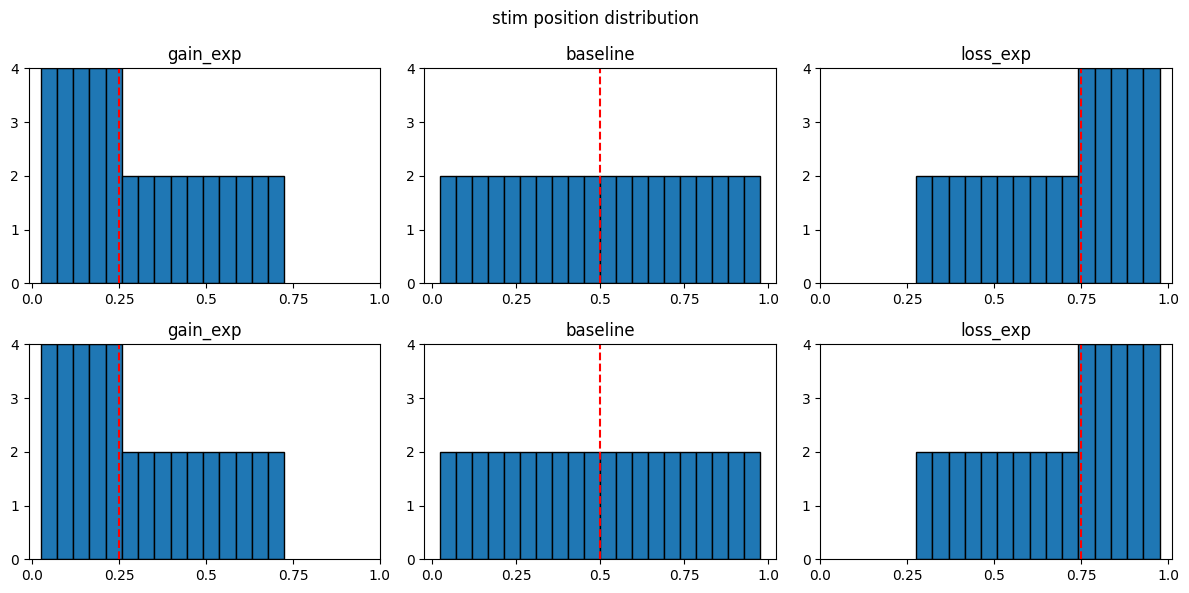

In [10]:
n_rows, n_cols = 2, 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0

for blockN in block_order:
    block_df = subj12_df[subj12_df['blockN'] == blockN]
    
    axs[ax].hist(block_df['stim_pos_aligned'], bins=block2bins[blockN], edgecolor='black')
    axs[ax].axvline(x=block_df['div_pos_aligned'].iloc[0], color='red', linestyle='--')

    axs[ax].set(title=block2cond[blockN], xticks=ticks, xticklabels=labels, ylim=(0, 4))
    ax += 1

plt.suptitle('stim position distribution')
plt.tight_layout()
plt.show()

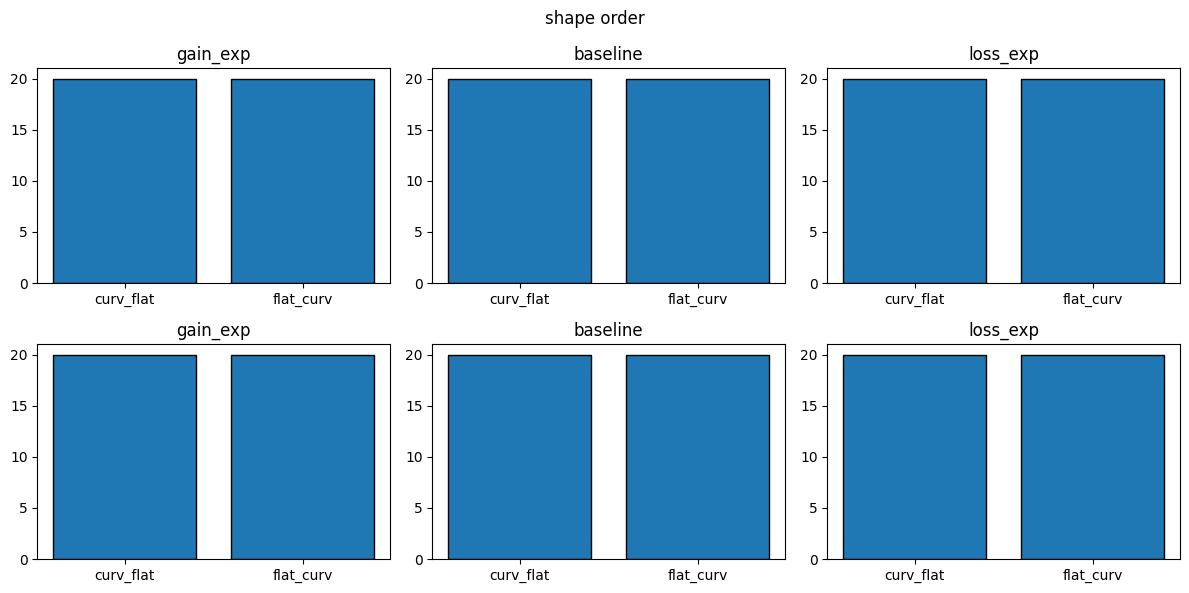

In [11]:
n_rows, n_cols = 2, 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0

for blockN in block_order:
    block_df = subj12_df[subj12_df['blockN'] == blockN]
    
    axs[ax].bar(block_df['shape_order'].value_counts().index, block_df['shape_order'].value_counts().values, edgecolor='black')

    axs[ax].set(title=block2cond[blockN])
    ax += 1

plt.suptitle('shape order')
plt.tight_layout()
plt.show()

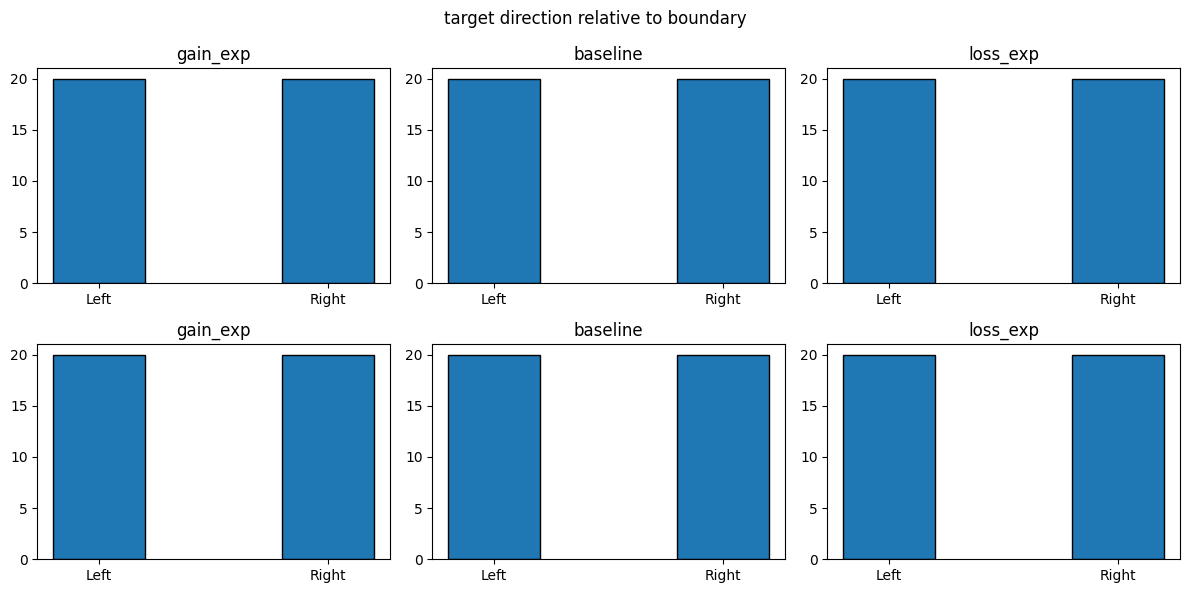

In [12]:
subj12_df['target_dir'] = np.sign(subj12_df['stim_pos_aligned'] - subj12_df['div_pos_aligned']).copy()

n_rows, n_cols = 2, 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0

for blockN in block_order:
    block_df = subj12_df[subj12_df['blockN'] == blockN]
    
    axs[ax].bar(block_df['target_dir'].value_counts().index, block_df['target_dir'].value_counts().values, edgecolor='black')

    axs[ax].set(title=block2cond[blockN], xticks=[-1, 1], xticklabels=['Left', 'Right'])
    ax += 1

plt.suptitle('target direction relative to boundary')
plt.tight_layout()
plt.show()

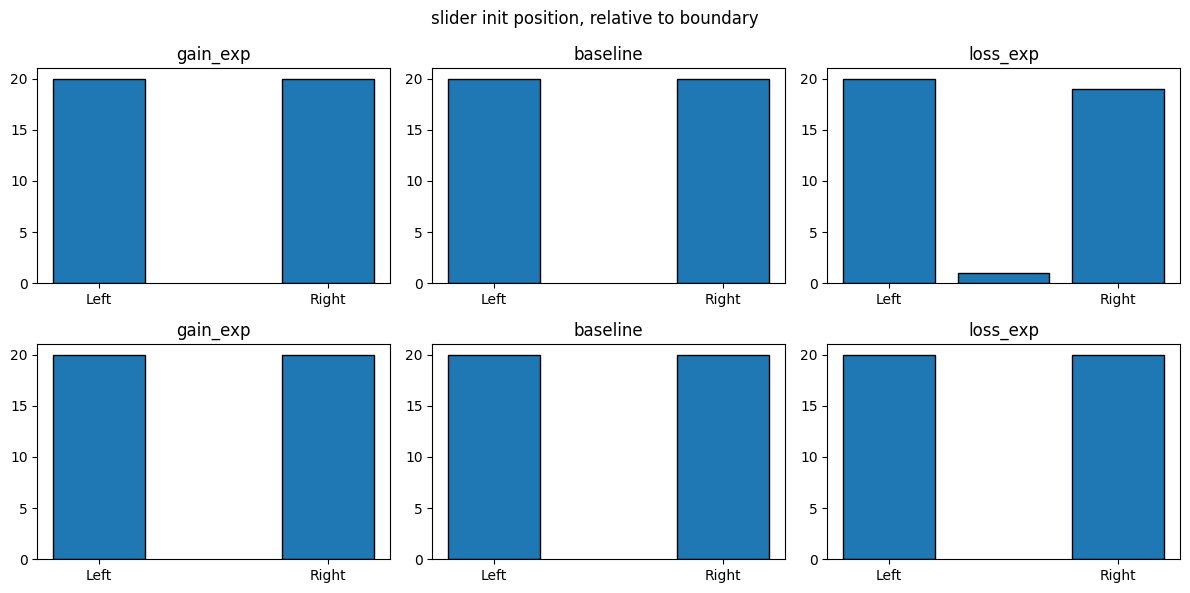

In [13]:
subj12_df['marker_side'] = np.sign(subj12_df['marker_init'] - subj12_df['div_pos_aligned']).copy()

n_rows, n_cols = 2, 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0

for blockN in block_order:
    block_df = subj12_df[subj12_df['blockN'] == blockN]

    axs[ax].bar(block_df['marker_side'].value_counts().index, block_df['marker_side'].value_counts().values, edgecolor='black')
    axs[ax].set(title=block2cond[blockN], xticks=[-1, 1], xticklabels=['Left', 'Right'])
    
    # axs[ax].hist(block_df['marker_init'], bins=40, edgecolor='black')
    # axs[ax].axvline(x=block_df['div_pos_aligned'].iloc[0], color='red', linestyle='--')
    # axs[ax].set(title=block2cond[blockN], xticks=ticks, xticklabels=labels, ylim=(0, 5))

    ax += 1

plt.suptitle('slider init position, relative to boundary')
# plt.suptitle('slider init position, distribution')
plt.tight_layout()
plt.show()

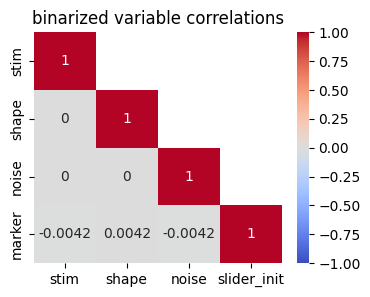

In [31]:
subj12_df['stim_dir'] = np.sign(subj12_df['stim_pos_aligned'] - subj12_df['div_pos_aligned'])
# subj12_df['stim_dir'] = np.sign(subj12_df['target_pos'] - subj12_df['div_pos'])
subj12_df['shape_dir'] = subj12_df['shape_order'].map({'curv_flat': 1, 'flat_curv': -1})
subj12_df['noise_dir'] = np.sign(subj12_df['noise_pos'] - 2.0)
subj12_df['marker_dir'] = np.sign(subj12_df['marker_init'] - subj12_df['div_pos_aligned'])

plt.figure(figsize=(4,3))
corr_mtx = np.corrcoef([subj12_df['stim_dir'], subj12_df['shape_dir'], subj12_df['noise_dir'], subj12_df['marker_dir']])
mask = np.triu(np.ones_like(corr_mtx, dtype=bool), k=1)
sns.heatmap(corr_mtx, annot=True, mask=mask, vmin=-1, vmax=1, cmap='coolwarm', center=0,
            xticklabels=['stim', 'shape', 'noise', 'slider_init'], yticklabels=['stim', 'shape', 'noise', 'marker'],)
plt.title('binarized variable correlations')
plt.show()

In [28]:
stim38_df = subj12_df[subj12_df['target_pos'] == -.38]
cols = ['target_pos', 'stim_dir', 'div_pos_aligned']
stim38_df[cols]

,target_pos,stim_dir,div_pos_aligned
0,-0.38,-1.0,0.0
39,-0.38,1.0,-0.0
40,-0.38,-1.0,-0.2
42,-0.38,-1.0,-0.2
117,-0.38,1.0,0.2
119,-0.38,1.0,0.2
120,-0.38,-1.0,0.0
159,-0.38,1.0,-0.0
160,-0.38,-1.0,-0.2
162,-0.38,-1.0,-0.2


In [32]:
base_df = subj12_df[subj12_df['condition'] == 'baseline']
gain_exp_df = subj12_df[subj12_df['condition'] == 'pen_comp']
loss_exp_df = subj12_df[subj12_df['condition'] == 'rew_comp']

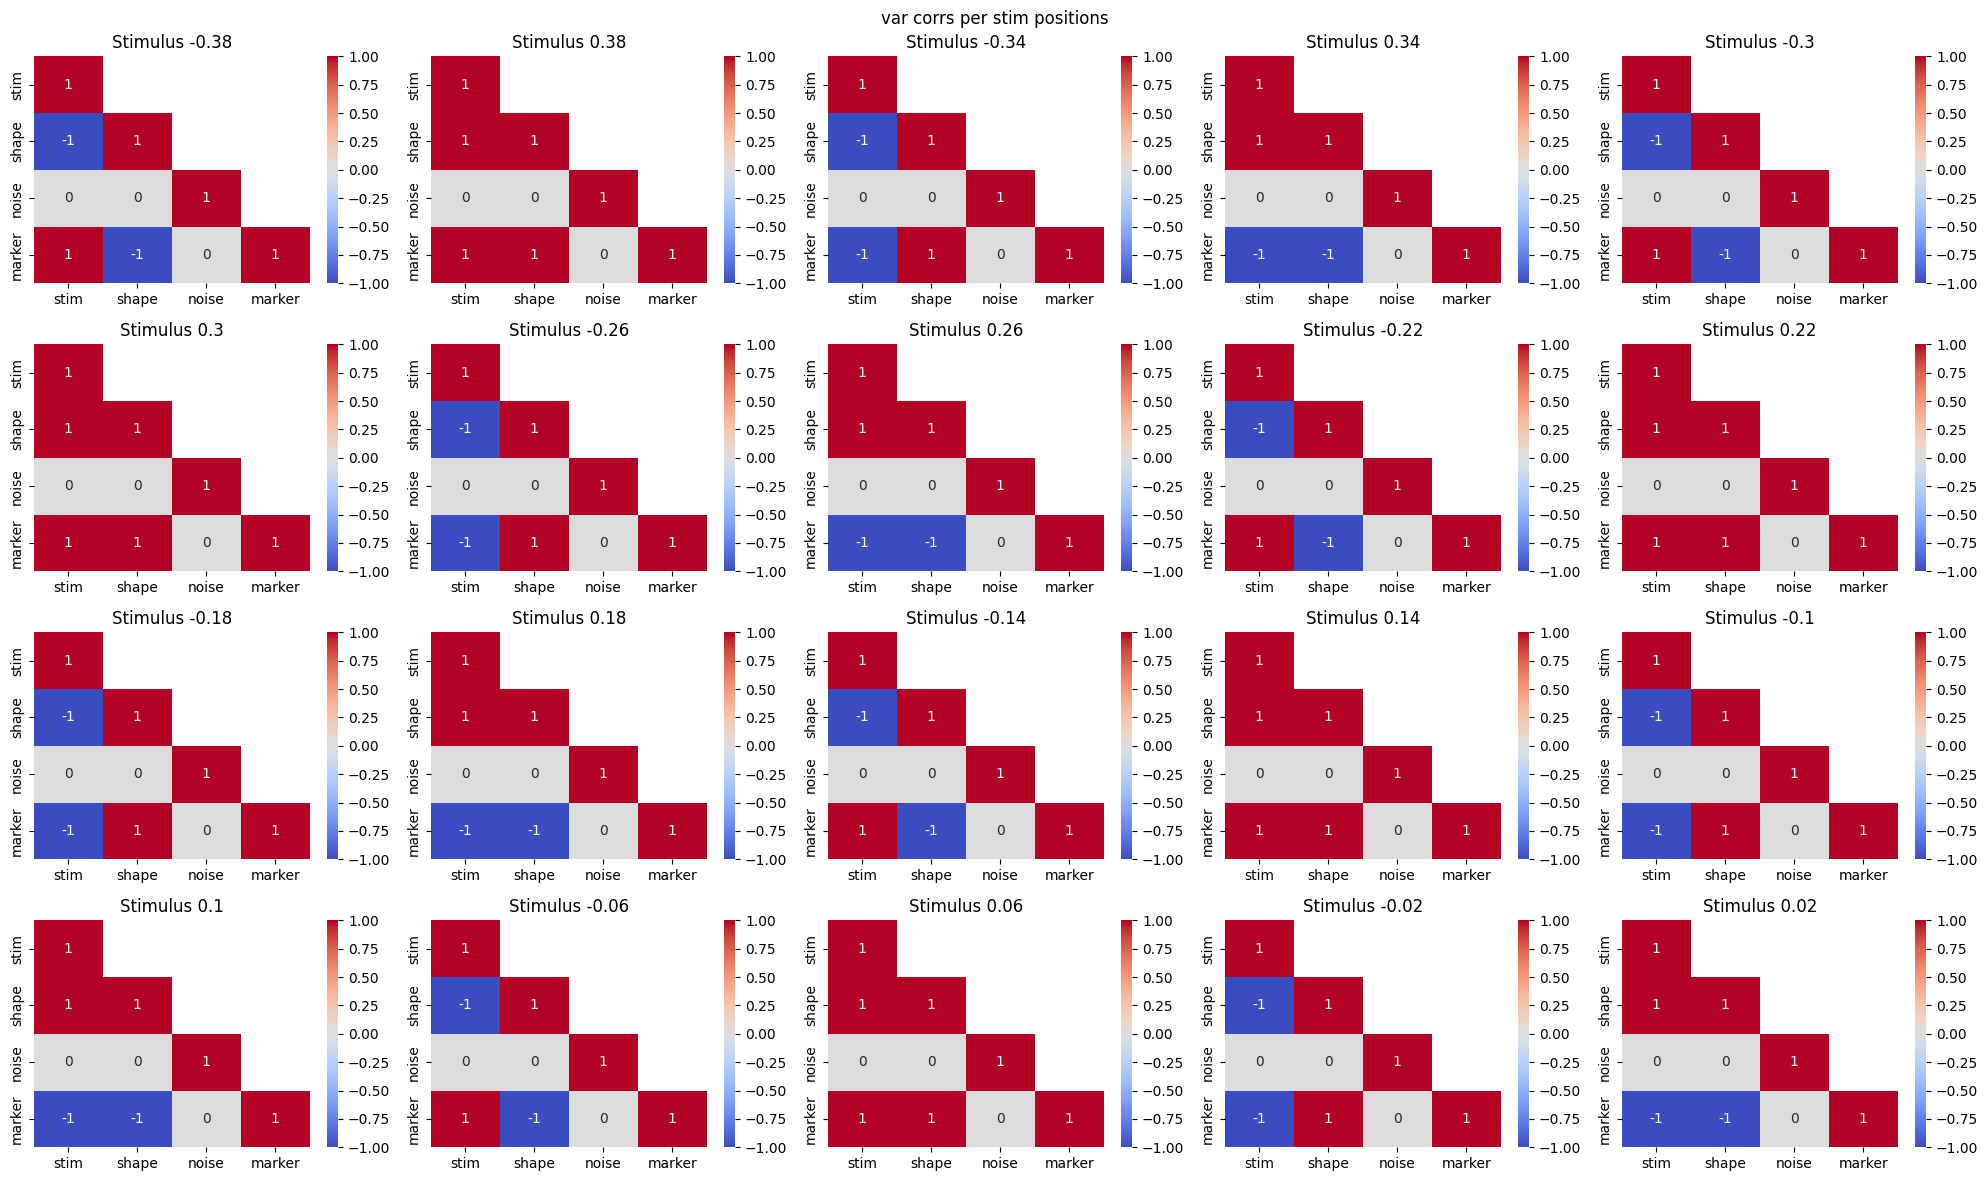

In [33]:
n_rows, n_cols = 4, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0

for unique_stim in base_df['target_pos'].unique():

    stim_df = base_df[base_df['target_pos'] == unique_stim]
    corr_mtx = np.round(np.corrcoef([stim_df['stim_dir'], stim_df['shape_dir'], stim_df['noise_dir'], stim_df['marker_dir']]), 2)
    sns.heatmap(corr_mtx, annot=True, mask=mask, vmin=-1, vmax=1, cmap='coolwarm', center=0, ax=axs[ax],
                xticklabels=['stim', 'shape', 'noise', 'marker'], yticklabels=['stim', 'shape', 'noise', 'marker'])

    axs[ax].set(title=f'Stimulus {unique_stim}')
    ax += 1

plt.suptitle('var corrs per stim positions')
plt.tight_layout()
plt.show()

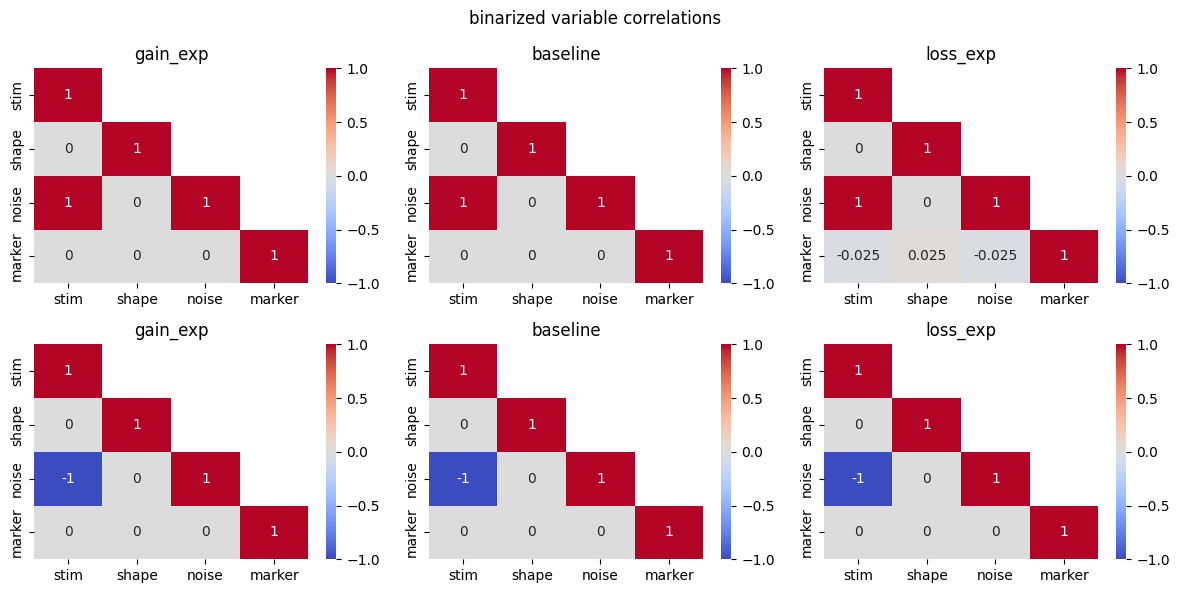

In [ ]:
n_rows, n_cols = 2, 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0

for blockN in block_order:
    block_df = subj12_df[subj12_df['blockN'] == blockN]

    stim_dir = np.sign(block_df['stim_pos_aligned'] - block_df['div_pos_aligned'])
    shape_dir = block_df['shape_order'].map({'curv_flat': 1, 'flat_curv': -1})
    noise_dir = np.sign(block_df['noise_pos'] - 2.0)
    marker_dir = np.sign(block_df['marker_init'] - block_df['div_pos_aligned'])

    corr_mtx = np.corrcoef([stim_dir, shape_dir, noise_dir, marker_dir])
    sns.heatmap(corr_mtx, annot=True, mask=mask, vmin=-1, vmax=1, cmap='coolwarm', center=0, ax=axs[ax],
                xticklabels=['stim', 'shape', 'noise', 'marker'], yticklabels=['stim', 'shape', 'noise', 'marker'])
    
    axs[ax].set(title=block2cond[blockN])
    ax += 1

plt.suptitle('binarized variable correlations')
plt.tight_layout()
plt.show()


In [ ]:
base_df = subj12_df[subj12_df['condition'] == 'baseline'].copy()

base_df['stim_dir'] = np.sign(base_df['stim_pos_aligned'] - base_df['div_pos_aligned']).copy()
base_df['shape_dir'] = base_df['shape_order'].map({'curv_flat': 1, 'flat_curv': -1}).copy()
base_df['noise_dir'] = np.sign(base_df['noise_pos'] - 2.0).copy()
base_df['marker_dir'] = np.sign(base_df['marker_init'] - base_df['div_pos_aligned']).copy()

cols = ['stim_pos_aligned', 'stim_dir', 'shape_dir', 'noise_dir', 'marker_dir']
base_df[cols].head(40)

,stim_pos_aligned,stim_dir,shape_dir,noise_dir,marker_dir
0,-0.38,-1.0,1,-1.0,-1.0
1,-0.38,-1.0,-1,-1.0,-1.0
2,-0.34,-1.0,1,-1.0,1.0
3,-0.34,-1.0,-1,-1.0,1.0
4,-0.30,-1.0,1,-1.0,-1.0
5,-0.30,-1.0,-1,-1.0,-1.0
6,-0.26,-1.0,1,-1.0,1.0
7,-0.26,-1.0,-1,-1.0,1.0
8,-0.22,-1.0,1,-1.0,-1.0
9,-0.22,-1.0,-1,-1.0,-1.0
